In [1]:
!pip install -q transformers
!pip install -q sentencepiece
!pip install -q jiwer
!pip install -q datasets
!pip install -q evaluate
!pip install -q -U accelerate

!pip install -q matplotlib
!pip install -q protobuf==3.20.1
!pip install -q tensorboard
!pip install elementpath
!pip install scikit-learn
!pip install numpy==1.26.4
!pip install transformers==4.45.2
!pip install git+https://github.com/huggingface/transformers@muellerzr-more-models-sadface

  Using cached transformers-4.45.2-py3-none-any.whl.metadata (44 kB)
  Using cached tokenizers-0.20.3-cp310-none-win_amd64.whl.metadata (6.9 kB)
Using cached transformers-4.45.2-py3-none-any.whl (9.9 MB)
Using cached tokenizers-0.20.3-cp310-none-win_amd64.whl (2.4 MB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.0
    Uninstalling tokenizers-0.21.0:
      Successfully uninstalled tokenizers-0.21.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.49.0.dev0
    Uninstalling transformers-4.49.0.dev0:
      Successfully uninstalled transformers-4.49.0.dev0
  Cloning https://github.com/huggingface/transformers (to revision muellerzr-more-models-sadface) to c:\users\dhlabadmin\appdata\local\temp\pip-req-build-46j0lun6
  Resolved https://github.com/huggingface/transformers to commit f8a963c116e6df9fb44f48da6875c12392e6e787
  Installing build dependencies: started
  Installing build dependencies: finished with status 'd

  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers 'C:\Users\dhlabadmin\AppData\Local\Temp\pip-req-build-46j0lun6'
  Running command git checkout -b muellerzr-more-models-sadface --track origin/muellerzr-more-models-sadface
  branch 'muellerzr-more-models-sadface' set up to track 'origin/muellerzr-more-models-sadface'.
  Switched to a new branch 'muellerzr-more-models-sadface'


In [62]:
import os
import torch
import evaluate
import numpy as np
import pandas as pd
import glob as glob
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from zipfile import ZipFile
from tqdm.notebook import tqdm
from dataclasses import dataclass
from torch.utils.data import Dataset
from urllib.request import urlretrieve
from transformers import (
    RobertaTokenizerFast,
    VisionEncoderDecoderModel, 
    TrOCRProcessor,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    default_data_collator
)

block_plot = False
plt.rcParams['figure.figsize'] = (12, 9)
bold = f"\033[1m"
reset = f"\033[0m"

## Pre-processing

In [89]:
# from sklearn.model_selection import train_test_split
image_dir = "C:/Users/dhlabadmin/Desktop/m-test/full-datasets/unpacked-datasets/6470048/"

# dataset = pd.read_csv(os.path.join(image_dir, "cropped_6470048.txt"), delimiter=",", header=None, names=["file_name", "text"], on_bad_lines="skip")
# dataset.head()

In [151]:
test_df = pd.read_csv(os.path.join(image_dir, "6470048_test.txt"), delimiter=",", header=None, names=["file_name", "text"], on_bad_lines="skip")
train_df = pd.read_csv(os.path.join(image_dir, "6470048_train.txt"), delimiter=",", header=None, names=["file_name", "text"], on_bad_lines="skip")

In [152]:
train_df.head()

,file_name,text
0,Ukrainka-0229_06.png,54. Славен у Бога Марисін по¬
1,Luk'anenko_last_pages-0003_09.png,по мамованно був зайтотий і я дітий.
2,Shev_Kobzar-0048_43.png,Господа молити.
3,shchodennyk-0024_37.png,"в нае почачась рознова щю Сжищів, в Якому я"
4,Luk'anenko_last_pages-0007_26.png,"зе паротя до Лохвиці, а там може спаю¬"


In [153]:
test_df.head()

,file_name,text
0,Ukrainka-0126_04.png,"на одну підводу скрині та перини,"
1,Luk'anenko_last_pages-0042_26.png,"загубив мене, відбив від життя."
2,Ukrainka-0080_16.png,-В Іванихи породіллі дитя калихала.
3,shchodennyk-0026_08.png,-Все розповів до найметшія дрібниць... чого же...
4,Luk'anenko_last_pages-0024_23.png,бону стилістики і навіть зміста


## Training

In [154]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [155]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int = 8
    EPOCHS:        int = 10
    LEARNING_RATE: float = 2e-5

@dataclass(frozen=True)
class DatasetConfig:
    DATA_ROOT:     str = image_dir
    # DATA_ROOT:     str = "test_polygon/small_dataset"

@dataclass(frozen=True)
class ModelConfig:
    MODEL_NAME: str = 'microsoft/trocr-base-handwritten'

In [118]:
# Augmentations.
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=.5, hue=.3),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    ])

In [179]:
class CustomOCRDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=512):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]

        # assert text.strip() != "", f"ERROR Empty text in {idx}"
        if isinstance(text, (int, float)) or text is None:
            text = str(text)
        if isinstance(text, list) or all(isinstance(t, str) for t in text):
            pass
        else:
            text = [str(t) for t in text]

        # Read the image, apply augmentations, and get the transformed pixels.
        image = Image.open(self.root_dir + file_name).convert('RGB')
        image = train_transforms(image)
        pixel_values = self.processor(image, return_tensors='pt').pixel_values
        # Pass the text through the tokenizer and get the labels,
        # i.e. tokenized labels.
        labels = self.processor.tokenizer(text,
                                          padding='max_length',
                                          max_length=self.max_target_length).input_ids

        # We are using -100 as the padding token.
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        # print(f"Dataset ouput keys: {encoding.keys()}")

        return encoding

In [169]:
# my_tokenizer = RobertaTokenizerFast.from_pretrained("create_tokenizer/my_tokenizer")
from transformers import AutoTokenizer
my_tokenizer = AutoTokenizer.from_pretrained("kazars24/trocr-base-handwritten-ru")

In [180]:
processor = TrOCRProcessor.from_pretrained(ModelConfig.MODEL_NAME)
processor.tokenizer = my_tokenizer

train_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, "6470048_train/"),
    df=train_df,
    processor=processor
)
valid_dataset = CustomOCRDataset(
    root_dir=os.path.join(DatasetConfig.DATA_ROOT, "6470048_test/"),
    df=test_df,
    processor=processor
)

In [197]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 19554
Number of validation examples: 4889


In [171]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# class CustomVisionEncoderDecoderModel(VisionEncoderDecoderModel):
#     def forward(self, *args, num_items_in_batch=None, **kwargs):
#         return super().forward(*args, **kwargs)

# model = CustomVisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME).to(device)

In [172]:
model = VisionEncoderDecoderModel.from_pretrained(ModelConfig.MODEL_NAME).to(device)
# print(model)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [173]:
# Set special tokens used for creating the decoder_input_ids from the labels.
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# Set Correct vocab size.
model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [174]:
optimizer = optim.AdamW(
    model.parameters(), lr=TrainingConfig.LEARNING_RATE, weight_decay=0.0005
)

In [175]:
cer_metric = evaluate.load('cer')

def compute_cer(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [181]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=TrainingConfig.BATCH_SIZE,
    per_device_eval_batch_size=TrainingConfig.BATCH_SIZE,
    fp16=True,
    output_dir='seq2seq_model_handwritten/',
    logging_steps=2,
    save_steps=int(len(train_dataset)/8),
    eval_steps=int(len(valid_dataset)/8),
    optim='adafactor',
    warmup_steps=int((len(valid_dataset)/8)),
    num_train_epochs=TrainingConfig.EPOCHS
)

c:\Users\dhlabadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [182]:
# from transformers import DataCollatorForSeq2Seq
# data_collator = DataCollatorForSeq2Seq(tokenizer=processor.tokenizer, model=model, padding=True)
# from transformers import Trainer
# from transformers.models.bart.modeling_bart import shift_tokens_right

# class CustomTrainer(Trainer):
#     def compute_loss(self, model, inputs, return_ouputs=False, **kwargs):
#         print(f"Input keys: {inputs.keys()}")

#         if 'num_items_in_batch' in kwargs:
#             kwargs.pop('num_items_in_batch')
        
#         labels = inputs.pop("labels")

#         # inputs["decoder_input_ids"] = shift_tokens_right(labels, model.config.pad_token_id,
#         #                                                  model.config.decoder_start_token_id)

#         outputs = model(**inputs)
#         loss = outputs.loss

#         return (loss, outputs) if return_ouputs else loss


# Initialize trainer.
trainer = Seq2SeqTrainer(model=model,
                         tokenizer=processor.tokenizer,
                         args=training_args,
                         compute_metrics=compute_cer,
                         train_dataset=train_dataset,
                         eval_dataset=valid_dataset,
                         data_collator=default_data_collator)

In [183]:
# trainer = CustomTrainer(model=model,
#                         args=training_args,
#                         compute_metrics=compute_cer,
#                         train_dataset=train_dataset,
#                         eval_dataset=valid_dataset,
#                         data_collator=default_data_collator)
res = trainer.train()

  0%|          | 0/24450 [00:00<?, ?it/s]

{'loss': 2.8848, 'grad_norm': 12.531203269958496, 'learning_rate': 8.183306055646481e-08, 'epoch': 0.0}
{'loss': 2.9978, 'grad_norm': 12.47116470336914, 'learning_rate': 2.4549918166939443e-07, 'epoch': 0.0}
{'loss': 2.7705, 'grad_norm': 9.9511137008667, 'learning_rate': 4.091653027823241e-07, 'epoch': 0.0}
{'loss': 2.6967, 'grad_norm': 11.811841011047363, 'learning_rate': 5.728314238952537e-07, 'epoch': 0.0}
{'loss': 2.7626, 'grad_norm': 11.449737548828125, 'learning_rate': 7.364975450081833e-07, 'epoch': 0.0}
{'loss': 2.7246, 'grad_norm': 7.958012104034424, 'learning_rate': 9.00163666121113e-07, 'epoch': 0.0}
{'loss': 2.7327, 'grad_norm': 9.242258071899414, 'learning_rate': 1.0638297872340427e-06, 'epoch': 0.01}
{'loss': 2.6542, 'grad_norm': 7.106251239776611, 'learning_rate': 1.227495908346972e-06, 'epoch': 0.01}
{'loss': 2.6455, 'grad_norm': 5.768300533294678, 'learning_rate': 1.391162029459902e-06, 'epoch': 0.01}
{'loss': 2.5329, 'grad_norm': 6.652783393859863, 'learning_rate': 1.

c:\Users\dhlabadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\generation\utils.py:1338: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 1.5759811401367188, 'eval_cer': 0.754895477752161, 'eval_runtime': 2617.1951, 'eval_samples_per_second': 1.868, 'eval_steps_per_second': 0.234, 'epoch': 0.25}
{'loss': 1.4787, 'grad_norm': 20.98042869567871, 'learning_rate': 4.9754500818330605e-05, 'epoch': 0.25}
{'loss': 1.7364, 'grad_norm': 32.37044143676758, 'learning_rate': 4.991816693944354e-05, 'epoch': 0.25}
{'loss': 1.4802, 'grad_norm': 19.061311721801758, 'learning_rate': 4.999790259658543e-05, 'epoch': 0.25}
{'loss': 1.8866, 'grad_norm': 29.790359497070312, 'learning_rate': 4.999370778975628e-05, 'epoch': 0.25}
{'loss': 2.1551, 'grad_norm': 15.92959213256836, 'learning_rate': 4.998951298292714e-05, 'epoch': 0.25}
{'loss': 1.6808, 'grad_norm': 25.86440658569336, 'learning_rate': 4.9985318176097994e-05, 'epoch': 0.25}
{'loss': 1.9651, 'grad_norm': 22.947296142578125, 'learning_rate': 4.998112336926884e-05, 'epoch': 0.26}
{'loss': 1.5751, 'grad_norm': 27.27913475036621, 'learning_rate': 4.99769285624397e-05, 'epoch

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 1.0182342529296875, 'eval_cer': 0.3467493551135179, 'eval_runtime': 2244.8224, 'eval_samples_per_second': 2.178, 'eval_steps_per_second': 0.273, 'epoch': 0.5}
{'loss': 0.8609, 'grad_norm': 17.701318740844727, 'learning_rate': 4.872477872393976e-05, 'epoch': 0.5}
{'loss': 1.1527, 'grad_norm': 10.704941749572754, 'learning_rate': 4.872058391711062e-05, 'epoch': 0.5}
{'loss': 0.9372, 'grad_norm': 9.54107666015625, 'learning_rate': 4.871638911028148e-05, 'epoch': 0.5}
{'loss': 0.9254, 'grad_norm': 10.676799774169922, 'learning_rate': 4.871219430345233e-05, 'epoch': 0.5}
{'loss': 1.0318, 'grad_norm': 8.513764381408691, 'learning_rate': 4.870799949662318e-05, 'epoch': 0.5}
{'loss': 1.0795, 'grad_norm': 7.812773704528809, 'learning_rate': 4.870380468979404e-05, 'epoch': 0.5}
{'loss': 0.7229, 'grad_norm': 16.01410675048828, 'learning_rate': 4.869960988296489e-05, 'epoch': 0.51}
{'loss': 1.0126, 'grad_norm': 11.244148254394531, 'learning_rate': 4.869541507613575e-05, 'epoch': 0.51

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.7667991518974304, 'eval_cer': 0.27060806986816316, 'eval_runtime': 2350.6992, 'eval_samples_per_second': 2.08, 'eval_steps_per_second': 0.26, 'epoch': 0.75}
{'loss': 0.8435, 'grad_norm': 9.342546463012695, 'learning_rate': 4.7445362641050385e-05, 'epoch': 0.75}
{'loss': 0.6842, 'grad_norm': 7.238503932952881, 'learning_rate': 4.7441167834221234e-05, 'epoch': 0.75}
{'loss': 0.9556, 'grad_norm': 14.93167781829834, 'learning_rate': 4.743697302739209e-05, 'epoch': 0.75}
{'loss': 0.752, 'grad_norm': 5.5526123046875, 'learning_rate': 4.7432778220562945e-05, 'epoch': 0.75}
{'loss': 0.5561, 'grad_norm': 11.993338584899902, 'learning_rate': 4.74285834137338e-05, 'epoch': 0.75}
{'loss': 0.8441, 'grad_norm': 7.552279949188232, 'learning_rate': 4.742438860690465e-05, 'epoch': 0.75}
{'loss': 0.8025, 'grad_norm': 11.391277313232422, 'learning_rate': 4.7420193800075505e-05, 'epoch': 0.76}
{'loss': 0.7163, 'grad_norm': 5.501465797424316, 'learning_rate': 4.741599899324636e-05, 'epoch':

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.6917623281478882, 'eval_cer': 0.2615468935237312, 'eval_runtime': 2376.416, 'eval_samples_per_second': 2.057, 'eval_steps_per_second': 0.258, 'epoch': 1.0}


c:\Users\dhlabadmin\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  """


{'loss': 0.4248, 'grad_norm': 4.665534496307373, 'learning_rate': 4.616175175133185e-05, 'epoch': 1.0}
{'loss': 0.8805, 'grad_norm': 8.197189331054688, 'learning_rate': 4.615755694450271e-05, 'epoch': 1.0}
{'loss': 0.6368, 'grad_norm': 6.1302714347839355, 'learning_rate': 4.6153362137673564e-05, 'epoch': 1.0}
{'loss': 0.6355, 'grad_norm': 9.81441879272461, 'learning_rate': 4.614916733084442e-05, 'epoch': 1.0}
{'loss': 0.775, 'grad_norm': 7.444290637969971, 'learning_rate': 4.6144972524015276e-05, 'epoch': 1.0}
{'loss': 0.812, 'grad_norm': 8.089305877685547, 'learning_rate': 4.6140777717186124e-05, 'epoch': 1.0}
{'loss': 0.6962, 'grad_norm': 5.836817264556885, 'learning_rate': 4.613658291035698e-05, 'epoch': 1.01}
{'loss': 0.5125, 'grad_norm': 8.327528953552246, 'learning_rate': 4.6132388103527836e-05, 'epoch': 1.01}
{'loss': 0.7562, 'grad_norm': 10.783088684082031, 'learning_rate': 4.612819329669869e-05, 'epoch': 1.01}
{'loss': 0.5603, 'grad_norm': 7.120226860046387, 'learning_rate': 4

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.6368001699447632, 'eval_cer': 0.24468154820414753, 'eval_runtime': 2346.7821, 'eval_samples_per_second': 2.083, 'eval_steps_per_second': 0.261, 'epoch': 1.25}
{'loss': 0.5704, 'grad_norm': 8.382523536682129, 'learning_rate': 4.488233566844247e-05, 'epoch': 1.25}
{'loss': 0.574, 'grad_norm': 15.924579620361328, 'learning_rate': 4.487814086161333e-05, 'epoch': 1.25}
{'loss': 0.6886, 'grad_norm': 8.245500564575195, 'learning_rate': 4.487394605478418e-05, 'epoch': 1.25}
{'loss': 0.6642, 'grad_norm': 5.102157115936279, 'learning_rate': 4.486975124795503e-05, 'epoch': 1.25}
{'loss': 0.4356, 'grad_norm': 5.978934288024902, 'learning_rate': 4.486555644112589e-05, 'epoch': 1.25}
{'loss': 0.5511, 'grad_norm': 5.9769287109375, 'learning_rate': 4.4861361634296744e-05, 'epoch': 1.25}
{'loss': 0.7693, 'grad_norm': 5.513583660125732, 'learning_rate': 4.485716682746759e-05, 'epoch': 1.25}
{'loss': 0.4954, 'grad_norm': 5.346092700958252, 'learning_rate': 4.485297202063845e-05, 'epoch': 

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.5879681706428528, 'eval_cer': 0.22719663527126935, 'eval_runtime': 2363.7615, 'eval_samples_per_second': 2.068, 'eval_steps_per_second': 0.259, 'epoch': 1.5}
{'loss': 0.5607, 'grad_norm': 6.026315689086914, 'learning_rate': 4.359872477872394e-05, 'epoch': 1.5}
{'loss': 0.5742, 'grad_norm': 26.207761764526367, 'learning_rate': 4.3594529971894796e-05, 'epoch': 1.5}
{'loss': 0.5688, 'grad_norm': 11.285311698913574, 'learning_rate': 4.359033516506565e-05, 'epoch': 1.5}
{'loss': 0.6087, 'grad_norm': 5.378818511962891, 'learning_rate': 4.358614035823651e-05, 'epoch': 1.5}
{'loss': 0.5599, 'grad_norm': 6.333376884460449, 'learning_rate': 4.358194555140736e-05, 'epoch': 1.5}
{'loss': 0.4233, 'grad_norm': 5.8965020179748535, 'learning_rate': 4.357775074457822e-05, 'epoch': 1.5}
{'loss': 0.5928, 'grad_norm': 4.698113441467285, 'learning_rate': 4.357355593774907e-05, 'epoch': 1.51}
{'loss': 0.5349, 'grad_norm': 4.630040645599365, 'learning_rate': 4.356936113091992e-05, 'epoch': 1.

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.5563099384307861, 'eval_cer': 0.21292870802280486, 'eval_runtime': 2364.0691, 'eval_samples_per_second': 2.068, 'eval_steps_per_second': 0.259, 'epoch': 1.75}
{'loss': 0.5606, 'grad_norm': 5.526303291320801, 'learning_rate': 4.231930869583456e-05, 'epoch': 1.75}
{'loss': 0.6047, 'grad_norm': 6.634463310241699, 'learning_rate': 4.2315113889005415e-05, 'epoch': 1.75}
{'loss': 0.364, 'grad_norm': 4.764067649841309, 'learning_rate': 4.231091908217627e-05, 'epoch': 1.75}
{'loss': 0.5582, 'grad_norm': 5.957697868347168, 'learning_rate': 4.230672427534712e-05, 'epoch': 1.75}
{'loss': 0.4821, 'grad_norm': 4.607937812805176, 'learning_rate': 4.2302529468517975e-05, 'epoch': 1.75}
{'loss': 0.7145, 'grad_norm': 5.46697998046875, 'learning_rate': 4.229833466168883e-05, 'epoch': 1.75}
{'loss': 0.5303, 'grad_norm': 4.603225231170654, 'learning_rate': 4.2294139854859686e-05, 'epoch': 1.75}
{'loss': 0.5151, 'grad_norm': 6.683111667633057, 'learning_rate': 4.2289945048030535e-05, 'epoch

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.5499743223190308, 'eval_cer': 0.20620878237091844, 'eval_runtime': 2385.3196, 'eval_samples_per_second': 2.05, 'eval_steps_per_second': 0.257, 'epoch': 2.0}
{'loss': 0.5577, 'grad_norm': 4.0824689865112305, 'learning_rate': 4.103569780611603e-05, 'epoch': 2.0}
{'loss': 0.4597, 'grad_norm': 5.0601701736450195, 'learning_rate': 4.103150299928688e-05, 'epoch': 2.0}
{'loss': 0.3266, 'grad_norm': 3.4119186401367188, 'learning_rate': 4.102730819245774e-05, 'epoch': 2.0}
{'loss': 0.3223, 'grad_norm': 4.492030143737793, 'learning_rate': 4.1023113385628594e-05, 'epoch': 2.0}
{'loss': 0.5125, 'grad_norm': 3.7661828994750977, 'learning_rate': 4.101891857879945e-05, 'epoch': 2.0}
{'loss': 0.8334, 'grad_norm': 5.058584213256836, 'learning_rate': 4.1014723771970305e-05, 'epoch': 2.0}
{'loss': 0.4417, 'grad_norm': 6.4041290283203125, 'learning_rate': 4.101052896514116e-05, 'epoch': 2.0}
{'loss': 0.3279, 'grad_norm': 5.105191707611084, 'learning_rate': 4.100633415831201e-05, 'epoch': 2

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4895677864551544, 'eval_cer': 0.1966412286502362, 'eval_runtime': 2372.1288, 'eval_samples_per_second': 2.061, 'eval_steps_per_second': 0.258, 'epoch': 2.25}
{'loss': 0.3831, 'grad_norm': 3.9993622303009033, 'learning_rate': 3.9756281723226646e-05, 'epoch': 2.25}
{'loss': 0.3734, 'grad_norm': 2.677994966506958, 'learning_rate': 3.97520869163975e-05, 'epoch': 2.25}
{'loss': 0.4348, 'grad_norm': 3.82816481590271, 'learning_rate': 3.974789210956836e-05, 'epoch': 2.25}
{'loss': 0.3061, 'grad_norm': 3.2140655517578125, 'learning_rate': 3.974369730273921e-05, 'epoch': 2.25}
{'loss': 0.514, 'grad_norm': 9.97727108001709, 'learning_rate': 3.973950249591006e-05, 'epoch': 2.25}
{'loss': 0.413, 'grad_norm': 4.272500991821289, 'learning_rate': 3.973530768908092e-05, 'epoch': 2.25}
{'loss': 0.4458, 'grad_norm': 3.4811527729034424, 'learning_rate': 3.9731112882251773e-05, 'epoch': 2.25}
{'loss': 0.3288, 'grad_norm': 5.596479415893555, 'learning_rate': 3.972691807542263e-05, 'epoch': 

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.5117940902709961, 'eval_cer': 0.19777908840157513, 'eval_runtime': 2371.0086, 'eval_samples_per_second': 2.062, 'eval_steps_per_second': 0.258, 'epoch': 2.5}
{'loss': 0.2999, 'grad_norm': 4.2813544273376465, 'learning_rate': 3.8472670833508114e-05, 'epoch': 2.5}
{'loss': 0.4672, 'grad_norm': 6.258569717407227, 'learning_rate': 3.846847602667897e-05, 'epoch': 2.5}
{'loss': 0.576, 'grad_norm': 9.431340217590332, 'learning_rate': 3.846428121984983e-05, 'epoch': 2.5}
{'loss': 0.4895, 'grad_norm': 7.744837284088135, 'learning_rate': 3.846008641302068e-05, 'epoch': 2.5}
{'loss': 0.3241, 'grad_norm': 4.060886859893799, 'learning_rate': 3.845589160619154e-05, 'epoch': 2.5}
{'loss': 0.4932, 'grad_norm': 6.280594825744629, 'learning_rate': 3.845169679936239e-05, 'epoch': 2.5}
{'loss': 0.2571, 'grad_norm': 3.9908361434936523, 'learning_rate': 3.844750199253325e-05, 'epoch': 2.5}
{'loss': 0.3818, 'grad_norm': 3.623460531234741, 'learning_rate': 3.8443307185704104e-05, 'epoch': 2.51

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.5002718567848206, 'eval_cer': 0.19434763700486718, 'eval_runtime': 2371.1499, 'eval_samples_per_second': 2.062, 'eval_steps_per_second': 0.258, 'epoch': 2.75}
{'loss': 0.5425, 'grad_norm': 6.426166534423828, 'learning_rate': 3.7193254750618734e-05, 'epoch': 2.75}
{'loss': 0.4293, 'grad_norm': 8.461145401000977, 'learning_rate': 3.718905994378959e-05, 'epoch': 2.75}
{'loss': 0.4056, 'grad_norm': 4.074605941772461, 'learning_rate': 3.7184865136960445e-05, 'epoch': 2.75}
{'loss': 0.5515, 'grad_norm': 9.54002571105957, 'learning_rate': 3.71806703301313e-05, 'epoch': 2.75}
{'loss': 0.408, 'grad_norm': 5.241490840911865, 'learning_rate': 3.717647552330215e-05, 'epoch': 2.75}
{'loss': 0.5213, 'grad_norm': 6.003683090209961, 'learning_rate': 3.7172280716473005e-05, 'epoch': 2.75}
{'loss': 0.705, 'grad_norm': 5.866544246673584, 'learning_rate': 3.716808590964386e-05, 'epoch': 2.75}
{'loss': 0.5048, 'grad_norm': 3.9666874408721924, 'learning_rate': 3.7163891102814716e-05, 'epoch'

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4545137882232666, 'eval_cer': 0.18109246450890332, 'eval_runtime': 2337.5396, 'eval_samples_per_second': 2.092, 'eval_steps_per_second': 0.262, 'epoch': 3.0}
{'loss': 0.2997, 'grad_norm': 3.5516626834869385, 'learning_rate': 3.590964386090021e-05, 'epoch': 3.0}
{'loss': 0.4832, 'grad_norm': 4.491642475128174, 'learning_rate': 3.5905449054071064e-05, 'epoch': 3.0}
{'loss': 0.3366, 'grad_norm': 4.032297134399414, 'learning_rate': 3.590125424724192e-05, 'epoch': 3.0}
{'loss': 0.2288, 'grad_norm': 5.840677738189697, 'learning_rate': 3.5897059440412775e-05, 'epoch': 3.0}
{'loss': 0.1875, 'grad_norm': 2.489776849746704, 'learning_rate': 3.5892864633583624e-05, 'epoch': 3.0}
{'loss': 0.2852, 'grad_norm': 4.1999640464782715, 'learning_rate': 3.588866982675448e-05, 'epoch': 3.0}
{'loss': 0.3148, 'grad_norm': 3.7710092067718506, 'learning_rate': 3.5884475019925335e-05, 'epoch': 3.0}
{'loss': 0.4052, 'grad_norm': 6.443337917327881, 'learning_rate': 3.588028021309619e-05, 'epoch': 

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4568837583065033, 'eval_cer': 0.1766244288361065, 'eval_runtime': 2398.1053, 'eval_samples_per_second': 2.039, 'eval_steps_per_second': 0.255, 'epoch': 3.25}
{'loss': 0.477, 'grad_norm': 18.513378143310547, 'learning_rate': 3.463022777801083e-05, 'epoch': 3.25}
{'loss': 0.3607, 'grad_norm': 4.310657024383545, 'learning_rate': 3.4626032971181676e-05, 'epoch': 3.25}
{'loss': 0.3219, 'grad_norm': 3.7141764163970947, 'learning_rate': 3.462183816435253e-05, 'epoch': 3.25}
{'loss': 0.3334, 'grad_norm': 2.6710758209228516, 'learning_rate': 3.461764335752339e-05, 'epoch': 3.25}
{'loss': 0.3127, 'grad_norm': 5.032583713531494, 'learning_rate': 3.461344855069424e-05, 'epoch': 3.25}
{'loss': 0.3846, 'grad_norm': 5.858151435852051, 'learning_rate': 3.460925374386509e-05, 'epoch': 3.25}
{'loss': 0.3504, 'grad_norm': 5.816099643707275, 'learning_rate': 3.460505893703595e-05, 'epoch': 3.25}
{'loss': 0.3373, 'grad_norm': 4.746562957763672, 'learning_rate': 3.4600864130206803e-05, 'epoc

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.45035049319267273, 'eval_cer': 0.1778456919200043, 'eval_runtime': 2345.0162, 'eval_samples_per_second': 2.085, 'eval_steps_per_second': 0.261, 'epoch': 3.5}
{'loss': 0.463, 'grad_norm': 3.7203598022460938, 'learning_rate': 3.3346616888292295e-05, 'epoch': 3.5}
{'loss': 0.4631, 'grad_norm': 4.194215297698975, 'learning_rate': 3.334242208146315e-05, 'epoch': 3.5}
{'loss': 0.3798, 'grad_norm': 5.5360636711120605, 'learning_rate': 3.333822727463401e-05, 'epoch': 3.5}
{'loss': 0.2477, 'grad_norm': 4.031441688537598, 'learning_rate': 3.333403246780486e-05, 'epoch': 3.5}
{'loss': 0.2231, 'grad_norm': 3.2525711059570312, 'learning_rate': 3.332983766097572e-05, 'epoch': 3.5}
{'loss': 0.5385, 'grad_norm': 7.929339408874512, 'learning_rate': 3.332564285414657e-05, 'epoch': 3.5}
{'loss': 0.238, 'grad_norm': 2.9428484439849854, 'learning_rate': 3.332144804731742e-05, 'epoch': 3.5}
{'loss': 0.3348, 'grad_norm': 3.1561739444732666, 'learning_rate': 3.331725324048828e-05, 'epoch': 3.5

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.43458038568496704, 'eval_cer': 0.17023215913355852, 'eval_runtime': 2370.1511, 'eval_samples_per_second': 2.063, 'eval_steps_per_second': 0.258, 'epoch': 3.75}
{'loss': 0.3078, 'grad_norm': 4.293365955352783, 'learning_rate': 3.206929820881748e-05, 'epoch': 3.75}
{'loss': 0.347, 'grad_norm': 4.814892292022705, 'learning_rate': 3.206510340198834e-05, 'epoch': 3.75}
{'loss': 0.3891, 'grad_norm': 3.7801713943481445, 'learning_rate': 3.2060908595159195e-05, 'epoch': 3.75}
{'loss': 0.3958, 'grad_norm': 2.6630280017852783, 'learning_rate': 3.205671378833005e-05, 'epoch': 3.75}
{'loss': 0.2869, 'grad_norm': 4.1419219970703125, 'learning_rate': 3.20525189815009e-05, 'epoch': 3.75}
{'loss': 0.3097, 'grad_norm': 3.439183473587036, 'learning_rate': 3.2048324174671755e-05, 'epoch': 3.75}
{'loss': 0.2851, 'grad_norm': 3.1190152168273926, 'learning_rate': 3.204412936784261e-05, 'epoch': 3.75}
{'loss': 0.3391, 'grad_norm': 3.2390189170837402, 'learning_rate': 3.2039934561013466e-05, '

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4122457802295685, 'eval_cer': 0.16826026605663086, 'eval_runtime': 2386.7204, 'eval_samples_per_second': 2.048, 'eval_steps_per_second': 0.256, 'epoch': 4.0}
{'loss': 0.4185, 'grad_norm': 3.139014482498169, 'learning_rate': 3.078568731909896e-05, 'epoch': 4.0}
{'loss': 0.2689, 'grad_norm': 6.433013916015625, 'learning_rate': 3.0781492512269814e-05, 'epoch': 4.0}
{'loss': 0.2306, 'grad_norm': 4.130405426025391, 'learning_rate': 3.077729770544067e-05, 'epoch': 4.0}
{'loss': 0.2705, 'grad_norm': 5.715360164642334, 'learning_rate': 3.0773102898611525e-05, 'epoch': 4.0}
{'loss': 0.2209, 'grad_norm': 6.577108860015869, 'learning_rate': 3.0768908091782374e-05, 'epoch': 4.0}
{'loss': 0.2352, 'grad_norm': 3.0515220165252686, 'learning_rate': 3.076471328495323e-05, 'epoch': 4.0}
{'loss': 0.2237, 'grad_norm': 2.597768545150757, 'learning_rate': 3.0760518478124085e-05, 'epoch': 4.0}
{'loss': 0.4047, 'grad_norm': 4.557220458984375, 'learning_rate': 3.075632367129494e-05, 'epoch': 4.

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.42100998759269714, 'eval_cer': 0.1656092315574381, 'eval_runtime': 2350.0673, 'eval_samples_per_second': 2.08, 'eval_steps_per_second': 0.26, 'epoch': 4.25}
{'loss': 0.2751, 'grad_norm': 4.028979301452637, 'learning_rate': 2.9506271236209577e-05, 'epoch': 4.25}
{'loss': 0.3181, 'grad_norm': 2.331068277359009, 'learning_rate': 2.9502076429380426e-05, 'epoch': 4.25}
{'loss': 0.3067, 'grad_norm': 3.7884678840637207, 'learning_rate': 2.9497881622551282e-05, 'epoch': 4.25}
{'loss': 0.2845, 'grad_norm': 3.9692232608795166, 'learning_rate': 2.9493686815722137e-05, 'epoch': 4.25}
{'loss': 0.259, 'grad_norm': 2.1357979774475098, 'learning_rate': 2.9489492008892993e-05, 'epoch': 4.25}
{'loss': 0.2666, 'grad_norm': 3.475691556930542, 'learning_rate': 2.9485297202063845e-05, 'epoch': 4.25}
{'loss': 0.1405, 'grad_norm': 2.770968198776245, 'learning_rate': 2.94811023952347e-05, 'epoch': 4.25}
{'loss': 0.5068, 'grad_norm': 6.005413055419922, 'learning_rate': 2.9476907588405557e-05, 'e

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4266156852245331, 'eval_cer': 0.17025598865714678, 'eval_runtime': 2409.1787, 'eval_samples_per_second': 2.029, 'eval_steps_per_second': 0.254, 'epoch': 4.5}
{'loss': 0.1207, 'grad_norm': 2.1958417892456055, 'learning_rate': 2.8224757749905617e-05, 'epoch': 4.5}
{'loss': 0.2381, 'grad_norm': 2.329854726791382, 'learning_rate': 2.8220562943076473e-05, 'epoch': 4.5}
{'loss': 0.41, 'grad_norm': 5.078378677368164, 'learning_rate': 2.821636813624733e-05, 'epoch': 4.5}
{'loss': 0.2657, 'grad_norm': 3.4489662647247314, 'learning_rate': 2.8212173329418178e-05, 'epoch': 4.5}
{'loss': 0.3291, 'grad_norm': 5.014412879943848, 'learning_rate': 2.8207978522589033e-05, 'epoch': 4.5}
{'loss': 0.1759, 'grad_norm': 3.358668565750122, 'learning_rate': 2.820378371575989e-05, 'epoch': 4.5}
{'loss': 0.2459, 'grad_norm': 3.1532678604125977, 'learning_rate': 2.8199588908930748e-05, 'epoch': 4.5}
{'loss': 0.2467, 'grad_norm': 3.3978898525238037, 'learning_rate': 2.8195394102101604e-05, 'epoch':

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.40460404753685, 'eval_cer': 0.16353606300526036, 'eval_runtime': 2357.3794, 'eval_samples_per_second': 2.074, 'eval_steps_per_second': 0.26, 'epoch': 4.75}
{'loss': 0.1821, 'grad_norm': 3.6228561401367188, 'learning_rate': 2.6945341667016233e-05, 'epoch': 4.75}
{'loss': 0.3379, 'grad_norm': 2.7107889652252197, 'learning_rate': 2.694114686018709e-05, 'epoch': 4.75}
{'loss': 0.3787, 'grad_norm': 3.6876163482666016, 'learning_rate': 2.6936952053357944e-05, 'epoch': 4.75}
{'loss': 0.2741, 'grad_norm': 4.102975368499756, 'learning_rate': 2.69327572465288e-05, 'epoch': 4.75}
{'loss': 0.2116, 'grad_norm': 2.1768722534179688, 'learning_rate': 2.692856243969965e-05, 'epoch': 4.75}
{'loss': 0.2932, 'grad_norm': 2.6270110607147217, 'learning_rate': 2.6924367632870508e-05, 'epoch': 4.75}
{'loss': 0.2477, 'grad_norm': 2.4283010959625244, 'learning_rate': 2.6920172826041364e-05, 'epoch': 4.75}
{'loss': 0.2554, 'grad_norm': 2.582987070083618, 'learning_rate': 2.691597801921222e-05, 'e

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4074539840221405, 'eval_cer': 0.16223735396970076, 'eval_runtime': 2393.0417, 'eval_samples_per_second': 2.043, 'eval_steps_per_second': 0.256, 'epoch': 5.0}
{'loss': 0.5865, 'grad_norm': 5.252215385437012, 'learning_rate': 2.5661730777297705e-05, 'epoch': 5.0}
{'loss': 0.2162, 'grad_norm': 3.8500328063964844, 'learning_rate': 2.565753597046856e-05, 'epoch': 5.0}
{'loss': 0.2356, 'grad_norm': 2.6140387058258057, 'learning_rate': 2.5653341163639416e-05, 'epoch': 5.0}
{'loss': 0.2592, 'grad_norm': 3.3520419597625732, 'learning_rate': 2.564914635681027e-05, 'epoch': 5.0}
{'loss': 0.1822, 'grad_norm': 2.702402114868164, 'learning_rate': 2.5644951549981124e-05, 'epoch': 5.0}
{'loss': 0.1956, 'grad_norm': 5.438635349273682, 'learning_rate': 2.564075674315198e-05, 'epoch': 5.0}
{'loss': 0.2153, 'grad_norm': 3.7387452125549316, 'learning_rate': 2.5636561936322835e-05, 'epoch': 5.0}
{'loss': 0.2445, 'grad_norm': 5.013710021972656, 'learning_rate': 2.563236712949369e-05, 'epoch':

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.41386178135871887, 'eval_cer': 0.16230884254046551, 'eval_runtime': 2367.2483, 'eval_samples_per_second': 2.065, 'eval_steps_per_second': 0.259, 'epoch': 5.25}
{'loss': 0.2422, 'grad_norm': 3.7369635105133057, 'learning_rate': 2.4382314694408324e-05, 'epoch': 5.25}
{'loss': 0.2301, 'grad_norm': 5.374753475189209, 'learning_rate': 2.437811988757918e-05, 'epoch': 5.25}
{'loss': 0.0906, 'grad_norm': 1.9224351644515991, 'learning_rate': 2.437392508075003e-05, 'epoch': 5.25}
{'loss': 0.1966, 'grad_norm': 2.629103660583496, 'learning_rate': 2.4369730273920887e-05, 'epoch': 5.25}
{'loss': 0.1184, 'grad_norm': 3.331002950668335, 'learning_rate': 2.436553546709174e-05, 'epoch': 5.25}
{'loss': 0.1904, 'grad_norm': 4.245923042297363, 'learning_rate': 2.4361340660262595e-05, 'epoch': 5.25}
{'loss': 0.1443, 'grad_norm': 2.1186277866363525, 'learning_rate': 2.435714585343345e-05, 'epoch': 5.25}
{'loss': 0.1742, 'grad_norm': 1.5870780944824219, 'learning_rate': 2.4352951046604306e-05,

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.40970757603645325, 'eval_cer': 0.15946717185256673, 'eval_runtime': 2383.7416, 'eval_samples_per_second': 2.051, 'eval_steps_per_second': 0.257, 'epoch': 5.5}
{'loss': 0.1758, 'grad_norm': 2.7733588218688965, 'learning_rate': 2.3098703804689795e-05, 'epoch': 5.5}
{'loss': 0.1561, 'grad_norm': 6.434066295623779, 'learning_rate': 2.309450899786065e-05, 'epoch': 5.5}
{'loss': 0.1946, 'grad_norm': 3.5483767986297607, 'learning_rate': 2.3090314191031503e-05, 'epoch': 5.5}
{'loss': 0.2739, 'grad_norm': 4.63079833984375, 'learning_rate': 2.308611938420236e-05, 'epoch': 5.5}
{'loss': 0.2443, 'grad_norm': 5.951165199279785, 'learning_rate': 2.308192457737321e-05, 'epoch': 5.5}
{'loss': 0.2059, 'grad_norm': 3.6280009746551514, 'learning_rate': 2.3077729770544067e-05, 'epoch': 5.5}
{'loss': 0.2022, 'grad_norm': 2.108013153076172, 'learning_rate': 2.3073534963714922e-05, 'epoch': 5.5}
{'loss': 0.2514, 'grad_norm': 3.980646848678589, 'learning_rate': 2.3069340156885778e-05, 'epoch':

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4000142514705658, 'eval_cer': 0.1576859149643451, 'eval_runtime': 2387.6147, 'eval_samples_per_second': 2.048, 'eval_steps_per_second': 0.256, 'epoch': 5.75}
{'loss': 0.2717, 'grad_norm': 4.4650373458862305, 'learning_rate': 2.182348252862956e-05, 'epoch': 5.75}
{'loss': 0.1986, 'grad_norm': 3.561522960662842, 'learning_rate': 2.1819287721800414e-05, 'epoch': 5.75}
{'loss': 0.2681, 'grad_norm': 4.721254348754883, 'learning_rate': 2.1815092914971266e-05, 'epoch': 5.75}
{'loss': 0.2342, 'grad_norm': 3.377237319946289, 'learning_rate': 2.1810898108142122e-05, 'epoch': 5.75}
{'loss': 0.2499, 'grad_norm': 3.143284320831299, 'learning_rate': 2.1806703301312974e-05, 'epoch': 5.75}
{'loss': 0.1712, 'grad_norm': 2.05473256111145, 'learning_rate': 2.180250849448383e-05, 'epoch': 5.75}
{'loss': 0.3457, 'grad_norm': 3.1743407249450684, 'learning_rate': 2.1798313687654682e-05, 'epoch': 5.75}
{'loss': 0.2323, 'grad_norm': 3.3798859119415283, 'learning_rate': 2.179411888082554e-05, 'e

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.39980262517929077, 'eval_cer': 0.15667911759274153, 'eval_runtime': 2384.2085, 'eval_samples_per_second': 2.051, 'eval_steps_per_second': 0.257, 'epoch': 6.0}
{'loss': 0.2277, 'grad_norm': 3.638076066970825, 'learning_rate': 2.053987163891103e-05, 'epoch': 6.0}
{'loss': 0.1888, 'grad_norm': 3.0450949668884277, 'learning_rate': 2.0535676832081886e-05, 'epoch': 6.0}
{'loss': 0.1859, 'grad_norm': 7.429990291595459, 'learning_rate': 2.0531482025252738e-05, 'epoch': 6.0}
{'loss': 0.2216, 'grad_norm': 4.826171398162842, 'learning_rate': 2.0527287218423594e-05, 'epoch': 6.0}
{'loss': 0.0994, 'grad_norm': 3.733046054840088, 'learning_rate': 2.0523092411594446e-05, 'epoch': 6.0}
{'loss': 0.1455, 'grad_norm': 3.437983751296997, 'learning_rate': 2.05188976047653e-05, 'epoch': 6.0}
{'loss': 0.1188, 'grad_norm': 1.9498181343078613, 'learning_rate': 2.0514702797936157e-05, 'epoch': 6.0}
{'loss': 0.2112, 'grad_norm': 3.3692119121551514, 'learning_rate': 2.0510507991107013e-05, 'epoch'

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.41731902956962585, 'eval_cer': 0.15814463329341888, 'eval_runtime': 2338.8209, 'eval_samples_per_second': 2.09, 'eval_steps_per_second': 0.262, 'epoch': 6.25}
{'loss': 0.1344, 'grad_norm': 3.0636346340179443, 'learning_rate': 1.9260455556021646e-05, 'epoch': 6.25}
{'loss': 0.2219, 'grad_norm': 2.018155813217163, 'learning_rate': 1.92562607491925e-05, 'epoch': 6.25}
{'loss': 0.1877, 'grad_norm': 2.846759557723999, 'learning_rate': 1.9252065942363357e-05, 'epoch': 6.25}
{'loss': 0.1552, 'grad_norm': 2.8925797939300537, 'learning_rate': 1.924787113553421e-05, 'epoch': 6.25}
{'loss': 0.111, 'grad_norm': 2.617568016052246, 'learning_rate': 1.9243676328705065e-05, 'epoch': 6.25}
{'loss': 0.1485, 'grad_norm': 2.2937567234039307, 'learning_rate': 1.9239481521875917e-05, 'epoch': 6.25}
{'loss': 0.1564, 'grad_norm': 1.814333438873291, 'learning_rate': 1.9235286715046773e-05, 'epoch': 6.25}
{'loss': 0.1262, 'grad_norm': 1.3639198541641235, 'learning_rate': 1.923109190821763e-05, '

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.41567710041999817, 'eval_cer': 0.1567446487826092, 'eval_runtime': 2320.6398, 'eval_samples_per_second': 2.107, 'eval_steps_per_second': 0.264, 'epoch': 6.5}
{'loss': 0.1056, 'grad_norm': 2.239523410797119, 'learning_rate': 1.7976844666303117e-05, 'epoch': 6.5}
{'loss': 0.1673, 'grad_norm': 5.352113246917725, 'learning_rate': 1.7972649859473973e-05, 'epoch': 6.5}
{'loss': 0.0849, 'grad_norm': 2.4228591918945312, 'learning_rate': 1.7968455052644825e-05, 'epoch': 6.5}
{'loss': 0.2168, 'grad_norm': 4.54140043258667, 'learning_rate': 1.796426024581568e-05, 'epoch': 6.5}
{'loss': 0.1873, 'grad_norm': 3.24151349067688, 'learning_rate': 1.7960065438986533e-05, 'epoch': 6.5}
{'loss': 0.1644, 'grad_norm': 2.6608026027679443, 'learning_rate': 1.795587063215739e-05, 'epoch': 6.5}
{'loss': 0.2467, 'grad_norm': 4.382290363311768, 'learning_rate': 1.7951675825328244e-05, 'epoch': 6.5}
{'loss': 0.1341, 'grad_norm': 2.45452618598938, 'learning_rate': 1.79474810184991e-05, 'epoch': 6.5}

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4174053966999054, 'eval_cer': 0.155291047843726, 'eval_runtime': 2328.8499, 'eval_samples_per_second': 2.099, 'eval_steps_per_second': 0.263, 'epoch': 6.75}
{'loss': 0.0924, 'grad_norm': 2.271979808807373, 'learning_rate': 1.6697428583413736e-05, 'epoch': 6.75}
{'loss': 0.1374, 'grad_norm': 2.7631912231445312, 'learning_rate': 1.669323377658459e-05, 'epoch': 6.75}
{'loss': 0.1407, 'grad_norm': 5.044056415557861, 'learning_rate': 1.6689038969755444e-05, 'epoch': 6.75}
{'loss': 0.1247, 'grad_norm': 2.5658092498779297, 'learning_rate': 1.6684844162926296e-05, 'epoch': 6.75}
{'loss': 0.1692, 'grad_norm': 3.5066323280334473, 'learning_rate': 1.6680649356097152e-05, 'epoch': 6.75}
{'loss': 0.1433, 'grad_norm': 3.4766650199890137, 'learning_rate': 1.6676454549268004e-05, 'epoch': 6.75}
{'loss': 0.0799, 'grad_norm': 2.283324718475342, 'learning_rate': 1.667225974243886e-05, 'epoch': 6.75}
{'loss': 0.1279, 'grad_norm': 2.5908453464508057, 'learning_rate': 1.6668064935609716e-05,

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4128916263580322, 'eval_cer': 0.15432595213840186, 'eval_runtime': 2365.851, 'eval_samples_per_second': 2.066, 'eval_steps_per_second': 0.259, 'epoch': 7.0}
{'loss': 0.1595, 'grad_norm': 3.0086162090301514, 'learning_rate': 1.5413817693695208e-05, 'epoch': 7.0}
{'loss': 0.1019, 'grad_norm': 2.527419328689575, 'learning_rate': 1.540962288686606e-05, 'epoch': 7.0}
{'loss': 0.157, 'grad_norm': 2.16833758354187, 'learning_rate': 1.5405428080036916e-05, 'epoch': 7.0}
{'loss': 0.1125, 'grad_norm': 2.3669893741607666, 'learning_rate': 1.5401233273207768e-05, 'epoch': 7.0}
{'loss': 0.1376, 'grad_norm': 4.197197914123535, 'learning_rate': 1.5397038466378623e-05, 'epoch': 7.0}
{'loss': 0.0542, 'grad_norm': 2.8411872386932373, 'learning_rate': 1.539284365954948e-05, 'epoch': 7.0}
{'loss': 0.0503, 'grad_norm': 2.2788586616516113, 'learning_rate': 1.5388648852720335e-05, 'epoch': 7.0}
{'loss': 0.1064, 'grad_norm': 2.7394251823425293, 'learning_rate': 1.5384454045891187e-05, 'epoch':

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4373568296432495, 'eval_cer': 0.15582125474356454, 'eval_runtime': 2389.2785, 'eval_samples_per_second': 2.046, 'eval_steps_per_second': 0.256, 'epoch': 7.25}
{'loss': 0.113, 'grad_norm': 2.3324997425079346, 'learning_rate': 1.4134401610805822e-05, 'epoch': 7.25}
{'loss': 0.1639, 'grad_norm': 4.7166361808776855, 'learning_rate': 1.4130206803976679e-05, 'epoch': 7.25}
{'loss': 0.0584, 'grad_norm': 2.587287664413452, 'learning_rate': 1.4126011997147531e-05, 'epoch': 7.25}
{'loss': 0.0833, 'grad_norm': 2.590259075164795, 'learning_rate': 1.4121817190318387e-05, 'epoch': 7.25}
{'loss': 0.0652, 'grad_norm': 2.441133975982666, 'learning_rate': 1.4117622383489241e-05, 'epoch': 7.25}
{'loss': 0.0897, 'grad_norm': 3.030013084411621, 'learning_rate': 1.4113427576660097e-05, 'epoch': 7.25}
{'loss': 0.1424, 'grad_norm': 3.358253002166748, 'learning_rate': 1.4109232769830949e-05, 'epoch': 7.25}
{'loss': 0.1069, 'grad_norm': 2.677510976791382, 'learning_rate': 1.4105037963001804e-05,

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4329011142253876, 'eval_cer': 0.1550944542741229, 'eval_runtime': 2395.5956, 'eval_samples_per_second': 2.041, 'eval_steps_per_second': 0.255, 'epoch': 7.5}
{'loss': 0.052, 'grad_norm': 2.2395617961883545, 'learning_rate': 1.2850790721087295e-05, 'epoch': 7.5}
{'loss': 0.0679, 'grad_norm': 2.700049877166748, 'learning_rate': 1.284659591425815e-05, 'epoch': 7.5}
{'loss': 0.1396, 'grad_norm': 3.382107973098755, 'learning_rate': 1.2842401107429003e-05, 'epoch': 7.5}
{'loss': 0.084, 'grad_norm': 1.757249116897583, 'learning_rate': 1.2838206300599858e-05, 'epoch': 7.5}
{'loss': 0.0989, 'grad_norm': 2.0592234134674072, 'learning_rate': 1.2834011493770712e-05, 'epoch': 7.5}
{'loss': 0.1762, 'grad_norm': 2.536503553390503, 'learning_rate': 1.2829816686941568e-05, 'epoch': 7.5}
{'loss': 0.1594, 'grad_norm': 7.802254676818848, 'learning_rate': 1.282562188011242e-05, 'epoch': 7.5}
{'loss': 0.0983, 'grad_norm': 2.788421869277954, 'learning_rate': 1.2821427073283276e-05, 'epoch': 7.

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.43595945835113525, 'eval_cer': 0.1538136173812545, 'eval_runtime': 2376.2063, 'eval_samples_per_second': 2.057, 'eval_steps_per_second': 0.258, 'epoch': 7.75}
{'loss': 0.1412, 'grad_norm': 2.7400665283203125, 'learning_rate': 1.157137463819791e-05, 'epoch': 7.75}
{'loss': 0.0869, 'grad_norm': 9.527425765991211, 'learning_rate': 1.1567179831368766e-05, 'epoch': 7.75}
{'loss': 0.1421, 'grad_norm': 3.4791173934936523, 'learning_rate': 1.156298502453962e-05, 'epoch': 7.75}
{'loss': 0.0869, 'grad_norm': 9.256758689880371, 'learning_rate': 1.1558790217710474e-05, 'epoch': 7.75}
{'loss': 0.0718, 'grad_norm': 4.370594024658203, 'learning_rate': 1.155459541088133e-05, 'epoch': 7.75}
{'loss': 0.0427, 'grad_norm': 1.825021743774414, 'learning_rate': 1.1550400604052184e-05, 'epoch': 7.75}
{'loss': 0.1462, 'grad_norm': 3.638214111328125, 'learning_rate': 1.1546205797223038e-05, 'epoch': 7.75}
{'loss': 0.0992, 'grad_norm': 4.051881790161133, 'learning_rate': 1.1542010990393893e-05, '

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.42948174476623535, 'eval_cer': 0.15434382428109306, 'eval_runtime': 2393.6569, 'eval_samples_per_second': 2.042, 'eval_steps_per_second': 0.256, 'epoch': 8.0}
{'loss': 0.0917, 'grad_norm': 2.541088819503784, 'learning_rate': 1.0287763748479384e-05, 'epoch': 8.0}
{'loss': 0.0925, 'grad_norm': 1.8027781248092651, 'learning_rate': 1.0283568941650238e-05, 'epoch': 8.0}
{'loss': 0.105, 'grad_norm': 2.438746929168701, 'learning_rate': 1.0279374134821091e-05, 'epoch': 8.0}
{'loss': 0.2008, 'grad_norm': 1.2843502759933472, 'learning_rate': 1.0275179327991945e-05, 'epoch': 8.0}
{'loss': 0.1419, 'grad_norm': 4.4304423332214355, 'learning_rate': 1.0270984521162801e-05, 'epoch': 8.0}
{'loss': 0.0444, 'grad_norm': 1.3729244470596313, 'learning_rate': 1.0266789714333655e-05, 'epoch': 8.0}
{'loss': 0.1205, 'grad_norm': 1.4795069694519043, 'learning_rate': 1.0262594907504509e-05, 'epoch': 8.0}
{'loss': 0.062, 'grad_norm': 1.429060697555542, 'learning_rate': 1.0258400100675365e-05, 'epo

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4557137191295624, 'eval_cer': 0.15268767239170972, 'eval_runtime': 2375.5837, 'eval_samples_per_second': 2.058, 'eval_steps_per_second': 0.258, 'epoch': 8.25}
{'loss': 0.0609, 'grad_norm': 1.128825306892395, 'learning_rate': 9.00834766559e-06, 'epoch': 8.25}
{'loss': 0.0704, 'grad_norm': 2.7719016075134277, 'learning_rate': 9.004152858760855e-06, 'epoch': 8.25}
{'loss': 0.0816, 'grad_norm': 4.489583969116211, 'learning_rate': 8.999958051931709e-06, 'epoch': 8.25}
{'loss': 0.0688, 'grad_norm': 2.595914602279663, 'learning_rate': 8.995763245102563e-06, 'epoch': 8.25}
{'loss': 0.0553, 'grad_norm': 2.3137357234954834, 'learning_rate': 8.991568438273419e-06, 'epoch': 8.25}
{'loss': 0.0631, 'grad_norm': 1.2791459560394287, 'learning_rate': 8.987373631444272e-06, 'epoch': 8.25}
{'loss': 0.052, 'grad_norm': 2.048945665359497, 'learning_rate': 8.983178824615126e-06, 'epoch': 8.25}
{'loss': 0.0888, 'grad_norm': 2.699969530105591, 'learning_rate': 8.97898401778598e-06, 'epoch': 8.

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.46152111887931824, 'eval_cer': 0.15288426596131277, 'eval_runtime': 2382.4386, 'eval_samples_per_second': 2.052, 'eval_steps_per_second': 0.257, 'epoch': 8.5}
{'loss': 0.0481, 'grad_norm': 1.6090636253356934, 'learning_rate': 7.726834179286045e-06, 'epoch': 8.5}
{'loss': 0.0365, 'grad_norm': 1.838989019393921, 'learning_rate': 7.722639372456899e-06, 'epoch': 8.5}
{'loss': 0.0464, 'grad_norm': 2.474515199661255, 'learning_rate': 7.718444565627752e-06, 'epoch': 8.5}
{'loss': 0.0524, 'grad_norm': 1.4241803884506226, 'learning_rate': 7.714249758798606e-06, 'epoch': 8.5}
{'loss': 0.0162, 'grad_norm': 1.8633503913879395, 'learning_rate': 7.710054951969462e-06, 'epoch': 8.5}
{'loss': 0.0773, 'grad_norm': 2.738147735595703, 'learning_rate': 7.705860145140318e-06, 'epoch': 8.5}
{'loss': 0.011, 'grad_norm': 0.8919779062271118, 'learning_rate': 7.701665338311172e-06, 'epoch': 8.5}
{'loss': 0.0516, 'grad_norm': 1.9424724578857422, 'learning_rate': 7.697470531482026e-06, 'epoch': 8.

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4670971632003784, 'eval_cer': 0.15017961503404642, 'eval_runtime': 2386.8671, 'eval_samples_per_second': 2.048, 'eval_steps_per_second': 0.256, 'epoch': 8.75}
{'loss': 0.039, 'grad_norm': 1.3343491554260254, 'learning_rate': 6.447418096396661e-06, 'epoch': 8.75}
{'loss': 0.0518, 'grad_norm': 2.592233657836914, 'learning_rate': 6.443223289567515e-06, 'epoch': 8.75}
{'loss': 0.108, 'grad_norm': 5.155892848968506, 'learning_rate': 6.43902848273837e-06, 'epoch': 8.75}
{'loss': 0.0758, 'grad_norm': 6.525408744812012, 'learning_rate': 6.434833675909224e-06, 'epoch': 8.75}
{'loss': 0.0501, 'grad_norm': 2.4038798809051514, 'learning_rate': 6.430638869080079e-06, 'epoch': 8.75}
{'loss': 0.0906, 'grad_norm': 2.659911632537842, 'learning_rate': 6.4264440622509335e-06, 'epoch': 8.75}
{'loss': 0.0665, 'grad_norm': 3.19488787651062, 'learning_rate': 6.422249255421787e-06, 'epoch': 8.75}
{'loss': 0.0378, 'grad_norm': 1.874334692955017, 'learning_rate': 6.418054448592642e-06, 'epoch': 

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4636916518211365, 'eval_cer': 0.1516451307347238, 'eval_runtime': 2379.7522, 'eval_samples_per_second': 2.054, 'eval_steps_per_second': 0.257, 'epoch': 9.0}
{'loss': 0.0508, 'grad_norm': 1.3647539615631104, 'learning_rate': 5.1638072066781326e-06, 'epoch': 9.0}
{'loss': 0.0235, 'grad_norm': 1.7390633821487427, 'learning_rate': 5.159612399848987e-06, 'epoch': 9.0}
{'loss': 0.059, 'grad_norm': 2.3245797157287598, 'learning_rate': 5.155417593019841e-06, 'epoch': 9.0}
{'loss': 0.087, 'grad_norm': 2.8974785804748535, 'learning_rate': 5.151222786190696e-06, 'epoch': 9.0}
{'loss': 0.0329, 'grad_norm': 1.8001799583435059, 'learning_rate': 5.147027979361551e-06, 'epoch': 9.0}
{'loss': 0.0354, 'grad_norm': 2.0094873905181885, 'learning_rate': 5.142833172532406e-06, 'epoch': 9.0}
{'loss': 0.0438, 'grad_norm': 2.812612295150757, 'learning_rate': 5.13863836570326e-06, 'epoch': 9.0}
{'loss': 0.0352, 'grad_norm': 1.2183442115783691, 'learning_rate': 5.1344435588741144e-06, 'epoch': 9.

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.47501781582832336, 'eval_cer': 0.1502808905092965, 'eval_runtime': 2395.4626, 'eval_samples_per_second': 2.041, 'eval_steps_per_second': 0.255, 'epoch': 9.25}
{'loss': 0.0262, 'grad_norm': 1.4292638301849365, 'learning_rate': 3.88439112378875e-06, 'epoch': 9.25}
{'loss': 0.0214, 'grad_norm': 0.7917110323905945, 'learning_rate': 3.880196316959604e-06, 'epoch': 9.25}
{'loss': 0.0095, 'grad_norm': 0.6469947695732117, 'learning_rate': 3.876001510130459e-06, 'epoch': 9.25}
{'loss': 0.0357, 'grad_norm': 1.854622721672058, 'learning_rate': 3.871806703301313e-06, 'epoch': 9.25}
{'loss': 0.0305, 'grad_norm': 2.424898386001587, 'learning_rate': 3.8676118964721675e-06, 'epoch': 9.25}
{'loss': 0.0383, 'grad_norm': 2.6367242336273193, 'learning_rate': 3.863417089643022e-06, 'epoch': 9.25}
{'loss': 0.0422, 'grad_norm': 2.109683036804199, 'learning_rate': 3.859222282813876e-06, 'epoch': 9.25}
{'loss': 0.0412, 'grad_norm': 2.519564151763916, 'learning_rate': 3.855027475984731e-06, 'epo

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4784461259841919, 'eval_cer': 0.15062046122042905, 'eval_runtime': 2368.8192, 'eval_samples_per_second': 2.064, 'eval_steps_per_second': 0.258, 'epoch': 9.5}
{'loss': 0.0635, 'grad_norm': 1.5797655582427979, 'learning_rate': 2.600780234070221e-06, 'epoch': 9.5}
{'loss': 0.0339, 'grad_norm': 0.9161499738693237, 'learning_rate': 2.5965854272410758e-06, 'epoch': 9.5}
{'loss': 0.0252, 'grad_norm': 2.3259453773498535, 'learning_rate': 2.59239062041193e-06, 'epoch': 9.5}
{'loss': 0.0677, 'grad_norm': 3.5764763355255127, 'learning_rate': 2.5881958135827845e-06, 'epoch': 9.5}
{'loss': 0.0137, 'grad_norm': 1.1349433660507202, 'learning_rate': 2.5840010067536393e-06, 'epoch': 9.5}
{'loss': 0.0457, 'grad_norm': 1.4351866245269775, 'learning_rate': 2.5798061999244937e-06, 'epoch': 9.5}
{'loss': 0.0291, 'grad_norm': 0.7504437565803528, 'learning_rate': 2.575611393095348e-06, 'epoch': 9.5}
{'loss': 0.0343, 'grad_norm': 1.65634024143219, 'learning_rate': 2.571416586266203e-06, 'epoch'

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.4766518473625183, 'eval_cer': 0.1496911098004873, 'eval_runtime': 2392.5533, 'eval_samples_per_second': 2.043, 'eval_steps_per_second': 0.256, 'epoch': 9.75}
{'loss': 0.0072, 'grad_norm': 0.3708800673484802, 'learning_rate': 1.3213641511808382e-06, 'epoch': 9.75}
{'loss': 0.0259, 'grad_norm': 1.7225688695907593, 'learning_rate': 1.3171693443516928e-06, 'epoch': 9.75}
{'loss': 0.0272, 'grad_norm': 1.8619470596313477, 'learning_rate': 1.3129745375225471e-06, 'epoch': 9.75}
{'loss': 0.0292, 'grad_norm': 1.5670918226242065, 'learning_rate': 1.3087797306934017e-06, 'epoch': 9.75}
{'loss': 0.0524, 'grad_norm': 1.8947559595108032, 'learning_rate': 1.3045849238642561e-06, 'epoch': 9.75}
{'loss': 0.0163, 'grad_norm': 2.840059280395508, 'learning_rate': 1.3003901170351105e-06, 'epoch': 9.75}
{'loss': 0.0193, 'grad_norm': 0.6826382875442505, 'learning_rate': 1.296195310205965e-06, 'epoch': 9.75}
{'loss': 0.0254, 'grad_norm': 1.7615729570388794, 'learning_rate': 1.2920005033768197e

  0%|          | 0/612 [00:00<?, ?it/s]

{'eval_loss': 0.47796958684921265, 'eval_cer': 0.14953026051626664, 'eval_runtime': 2381.694, 'eval_samples_per_second': 2.053, 'eval_steps_per_second': 0.257, 'epoch': 10.0}
{'loss': 0.0316, 'grad_norm': 1.1073777675628662, 'learning_rate': 3.7753261462309664e-08, 'epoch': 10.0}
{'loss': 0.022, 'grad_norm': 1.499564528465271, 'learning_rate': 3.3558454633164143e-08, 'epoch': 10.0}
{'loss': 0.0333, 'grad_norm': 1.5738413333892822, 'learning_rate': 2.936364780401863e-08, 'epoch': 10.0}
{'loss': 0.0287, 'grad_norm': 1.9974771738052368, 'learning_rate': 2.5168840974873106e-08, 'epoch': 10.0}
{'loss': 0.002, 'grad_norm': 0.12689495086669922, 'learning_rate': 2.0974034145727592e-08, 'epoch': 10.0}
{'train_runtime': 121301.411, 'train_samples_per_second': 1.612, 'train_steps_per_second': 0.202, 'train_loss': 0.34297699585381763, 'epoch': 10.0}


In [184]:
final_model = model.save_pretrained("cyrillic_seq2seq_trocr_21")

## Evaluation

In [186]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
trained_model = VisionEncoderDecoderModel.from_pretrained("cyrillic_seq2seq_trocr_21").to(device)

Pixel values:  tensor([[[[0.6627, 0.6392, 0.6471,  ..., 0.7647, 0.6549, 0.6000],
          [0.6627, 0.6392, 0.6471,  ..., 0.7647, 0.6549, 0.6000],
          [0.6627, 0.6392, 0.6471,  ..., 0.7647, 0.6549, 0.6000],
          ...,
          [0.8902, 0.8902, 0.8824,  ..., 0.5922, 0.4196, 0.2627],
          [0.8902, 0.8902, 0.8824,  ..., 0.5922, 0.4196, 0.2627],
          [0.8902, 0.8902, 0.8824,  ..., 0.5922, 0.4196, 0.2627]],

         [[0.4824, 0.4902, 0.5137,  ..., 0.6314, 0.5294, 0.4745],
          [0.4824, 0.4902, 0.5137,  ..., 0.6314, 0.5294, 0.4745],
          [0.4824, 0.4902, 0.5137,  ..., 0.6314, 0.5294, 0.4745],
          ...,
          [0.7020, 0.7020, 0.6863,  ..., 0.4588, 0.3020, 0.1529],
          [0.7020, 0.7020, 0.6863,  ..., 0.4588, 0.3020, 0.1529],
          [0.7020, 0.7020, 0.6863,  ..., 0.4588, 0.3020, 0.1529]],

         [[0.3176, 0.2863, 0.3176,  ..., 0.4667, 0.3961, 0.3804],
          [0.3176, 0.2863, 0.3176,  ..., 0.4667, 0.3961, 0.3804],
          [0.3176, 0.2863, 

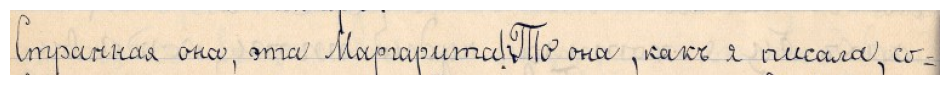

In [229]:
image = Image.open("rus_1.png").convert("RGB")
plt.imshow(image)
plt.axis('off')

pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
print("Pixel values: ", pixel_values)
print("Shape: ", pixel_values.shape)

trained_model.eval()
# with torch.no_grad():
generated_ids = trained_model.generate(pixel_values)
if -100 in generated_ids:
    print("found -100")
print("Generated token ids: ", generated_ids)
generated_text = processor.batch_decode(generated_ids, skip_special_token=True)[0]
print("Predicted text:", generated_text)

In [194]:
def ocr(image, processor, model):
    """
    :param image: PIL Image.
    :param processor: Huggingface OCR processor.
    :param model: Huggingface OCR model.

    Returns:
        generated_text: the OCR'd text string.
    """
    # We can directly perform OCR on cropped images.
    pixel_values = processor(image, return_tensors='pt').pixel_values.to(device)
    generated_ids = model.generate(pixel_values)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

In [200]:
def read_and_show(image_path):
    """
    :param image_path: String, path to the input image.

    Returns:
        image: PIL Image.
    """
    image = Image.open(image_path).convert('RGB')
    return image

In [227]:
import random

def eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, '6470048_test', '*'),
    num_samples=20
):
    files = os.listdir(data_path)
    images = [file for file in files if file.lower().endswith((".jpg", ".png", ".tif", "jpeg"))]

    i = 20
    while i > 0:
        random_image = random.choice(images)
        random_image_path = os.path.join(data_path, random_image)

        image = read_and_show(random_image_path)
        name = os.path.join(random_image_path)
        image = Image.open(name).convert('RGB')
        text = ocr(image, processor, trained_model)
        plt.figure(figsize=(7, 4))
        plt.imshow(image)
        plt.title(text)
        plt.suptitle(name)
        plt.axis('off')
        plt.show()

        i -= 1
    # image_paths = glob.glob(data_path)
    # for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    #     if i == num_samples:
    #         break
    #     image = read_and_show(image_path)
    #     name = os.path.join(image_path)
    #     image = Image.open(name).convert('RGB')
    #     text = ocr(image, processor, trained_model)
    #     plt.figure(figsize=(7, 4))
    #     plt.imshow(image)
    #     plt.title(text)
    #     plt.suptitle(name)
    #     plt.axis('off')
    #     plt.show()

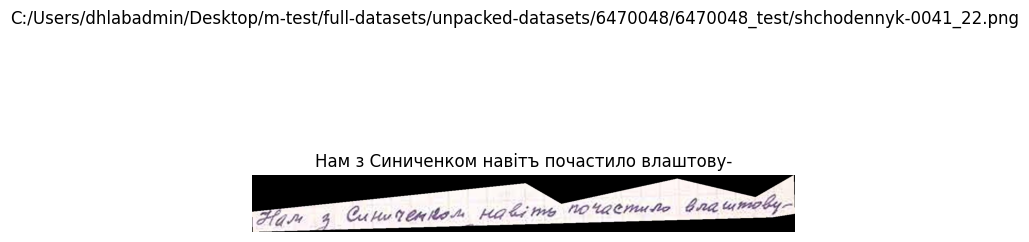

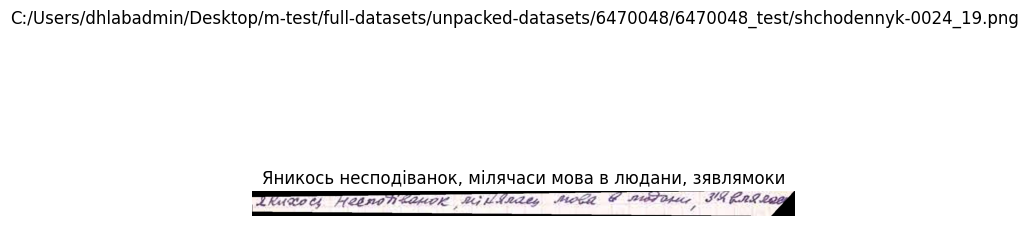

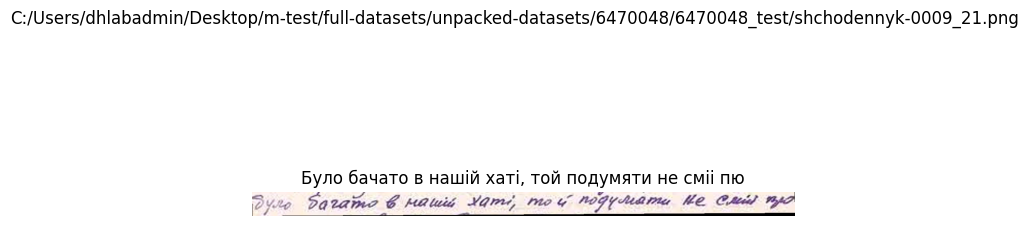

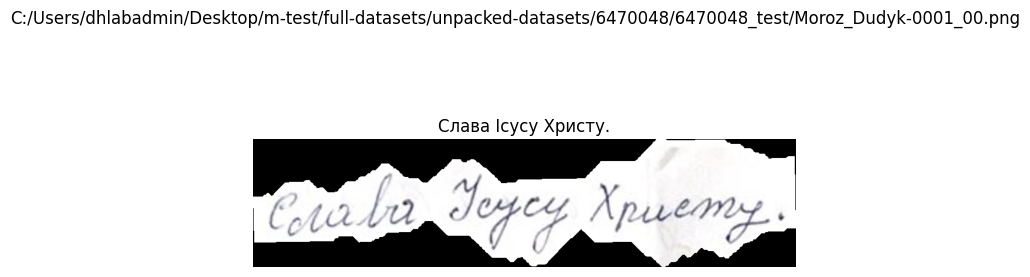

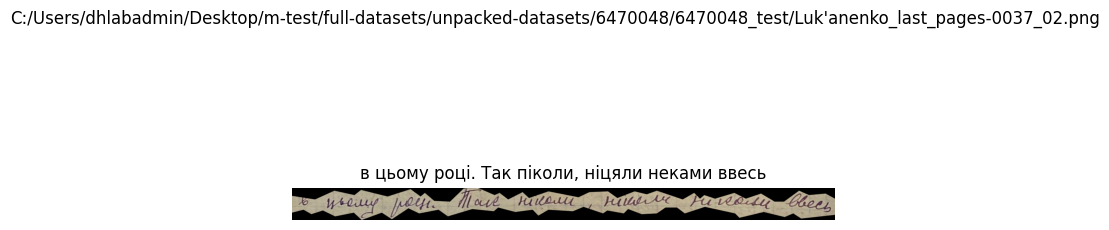

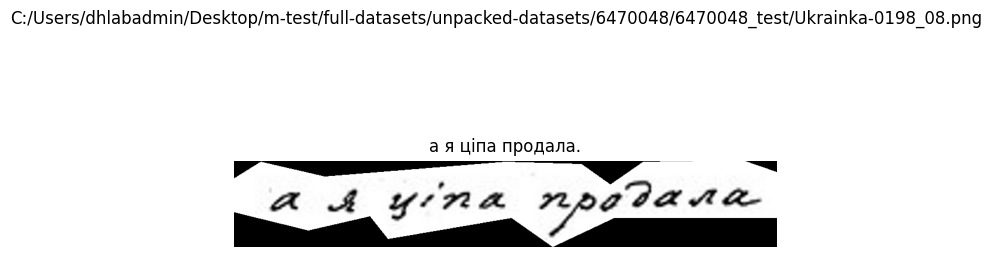

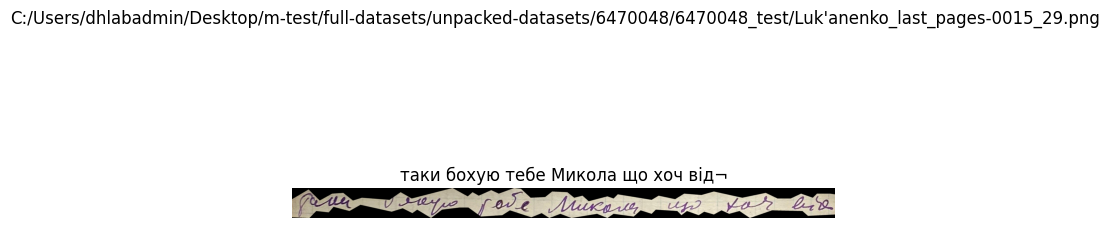

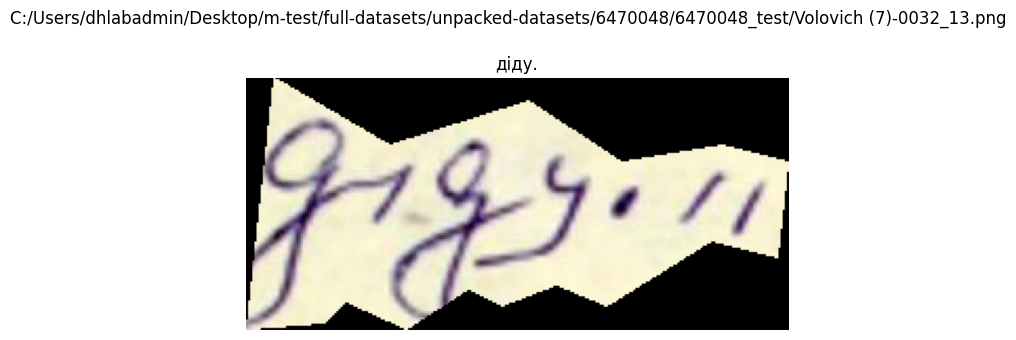

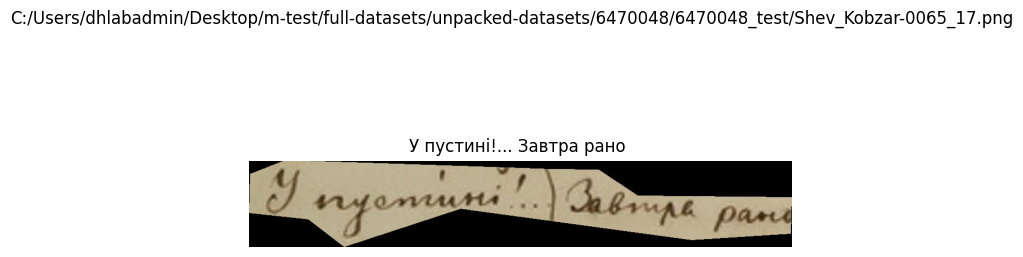

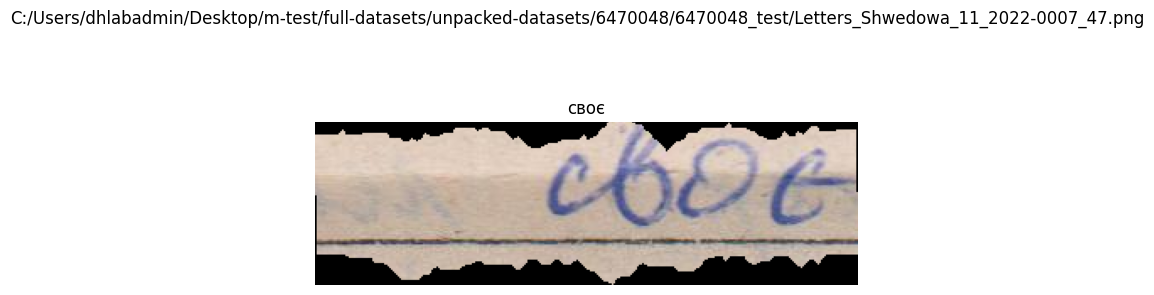

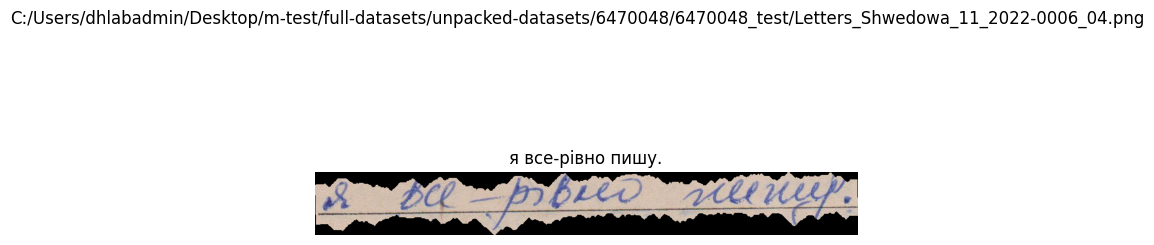

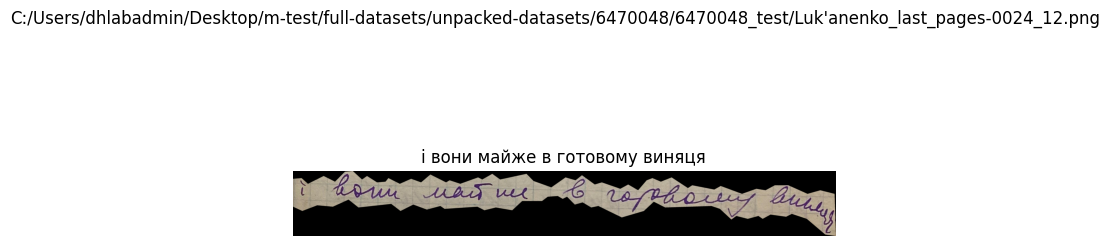

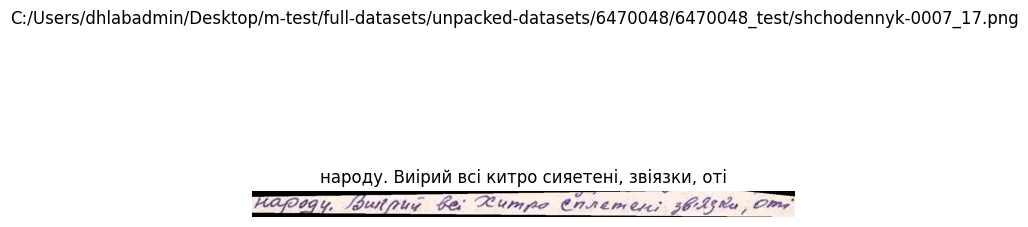

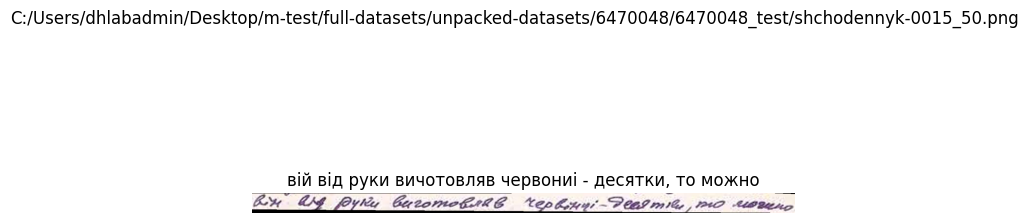

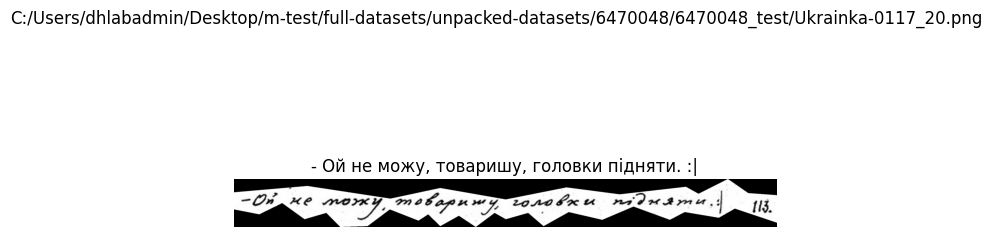

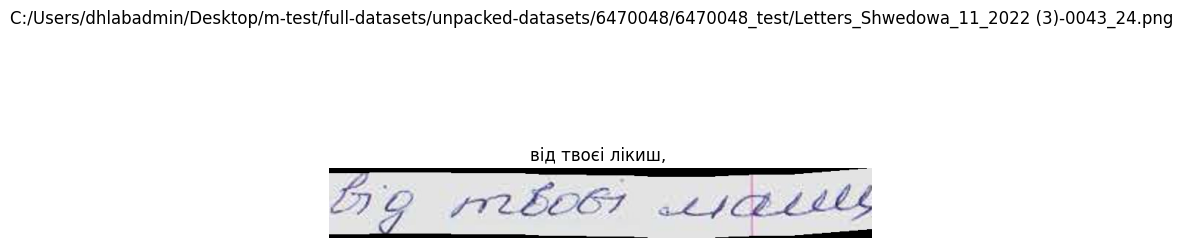

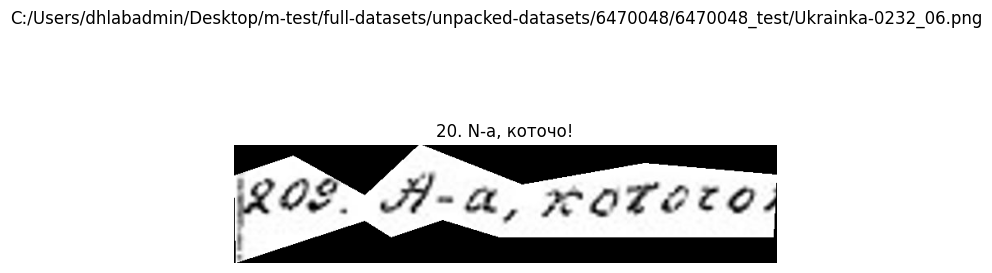

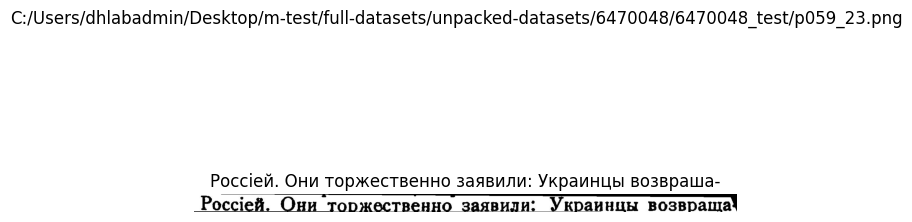

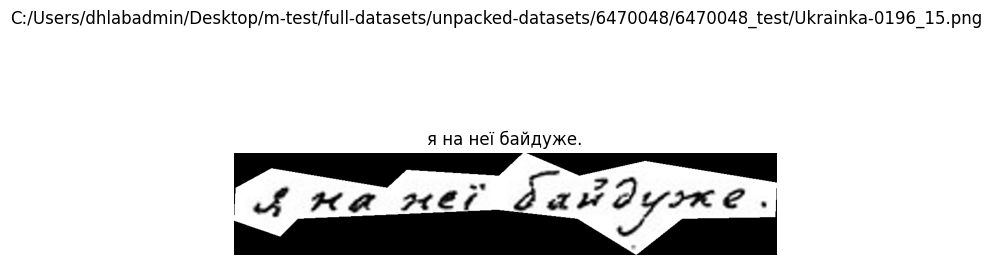

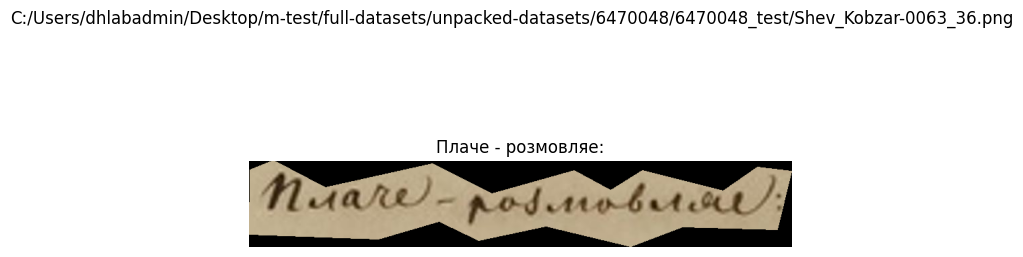

In [228]:
eval_new_data(
    data_path=os.path.join(DatasetConfig.DATA_ROOT, '6470048_test/'),
    num_samples=20
)